---

# CSCI 3202, Fall 2021
# Homework 5
# Due: Friday November 19, 2021 at 6:00 PM

<br> 

### Your name: Jaryd Meek

<br> 


---
## Problem 1: Navigating an awkward situation with grace and poise

<img src='https://www.explainxkcd.com/wiki/images/5/5f/interaction.png' style="width: 600px;"/>


Suppose you are at a social event where you would like to avoid any interaction with a large number of the other attendees. It's not that you don't like them, it's just that you don't like *talking to* them. A few of your good friends are also in attendance, but they are tucked away in a corner. The rectangular room in which the event is being held spans gridcells at $x=1,2,\ldots, 6$ and $y=1,2,\ldots, 5$. At the eastern edge ($x=6$) of this first floor room, there is a balcony, with a 6-foot drop. If the event becomes unbearably awkward, you can jump off the balcony and run away. Of course, this might hurt a little bit, so we should incorporate this into our reward structure.

The terminal states and rewards associated with them are given in the diagram below. The states are represented as $(x,y)$ tuples. The available actions in non-terminal states include moving exactly 1 unit North (+y), South (-y), East (+x) or West (-x), although you should not include walking into walls, because that would be embarrassing in front of all these other people. Represent actions as one of 'N', 'S', 'E', or 'W'. For now, assume all non-terminal states have a default reward of -0.01, and use a discount factor of 0.99.

<img src="http://www.cs.colorado.edu/~tonyewong/home/resources/hw06_mdp.png" style="width: 400px;"/>

Use the following transition model for this decision process, if you are trying to move from state $s$ to state $s'$:
* you successfully move from $s$ to $s'$ with probability 0.6
* the remaining 0.4 probability is spread equally likely across state $s$ **and** all adjacent (N/S/E/W) states except for $s'$. Note that this does not necessarily mean that all adjacent states have 0.1, because some states do not have 4 adjacent states.


### (1a)

Complete the `MDP` class below. The docstring comments provide some desired specifications. You may add additional methods or attributes, if you would like.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import unittest

In [2]:
class MDP:
    def __init__(self, nrow, ncol, terminal, default_reward, discount):
        '''Create/store the following attributes:
        states -- list of all the states (x,y) tuples
        terminal_states -- is a dictionary with terminal state keys, and rewards as values
        default_reward -- is the reward for being in any non-terminal state
        df -- discount factor
        ... and anything else you decide will be useful!
        '''
        
        # your code goes here...
        self.nrow = nrow
        self.ncol = ncol
        self.states = []
        self.terminal_states = terminal
        self.default_reward = default_reward
        self.df = discount
        
        #initialize arrays
        for x in range(ncol):
            for y in range(nrow):
                self.states.append((x+1,y+1))
        self.utility = [[0 for x in range(ncol+1)] for y in range(nrow+1)]
        
        

    def actions(self, state):
        '''Return a list of available actions from the given state.
        [None] are the actions available from a terminal state.
        '''
        
        # your code goes here...
        output = []
        if state in self.terminal_states:
            output = [None]
        else:
            if state[1] != self.nrow:
                output.append('N')
            if state[0] != self.ncol:
                output.append('E')
            if state[1] != 1:
                output.append('S')
            if state[0] != 1:
                output.append('W')
        return output
        
        
    def reward(self, state):
        '''Return the reward for being in the given state'''
        
        # your code goes here...
        if state in self.terminal_states:
            return self.terminal_states[state]
        else:
            return self.default_reward
        
        
    def result(self, state, action):
        '''Return the resulting state (as a tuple) from doing the given
        action in the given state, without uncertainty. Uncertainty
        is incorporated into the transition method.
        state -- a tuple representing the current state
        action -- one of N, S, E or W, as a string
        '''
    
        # your code goes here...
        if state in self.terminal_states:
            return None
        if action == 'N':
            return (state[0], state[1]+1)
        elif action == 'E':
            return (state[0]+1, state[1])
        elif action == 'S':
            return (state[0], state[1]-1)
        elif action == 'W':
            return (state[0]-1, state[1])
        
                
    def transition(self, state, action):
        '''Return the probabilities and subsequent states associated
        with taking the given action from the given state. Can be done
        however you want, so that it works with your value/policy iteration.
        '''
        
        # your code goes here...
        output = []
        if action is None:
            output = [(0, state)]
        else:
            moves = self.actions(state)
            moves.remove(action)
            output = [(.6, self.result(state, action))]
            for move in moves:
                output.append((.4/len(moves), self.result(state, move)))
            
        return output
        

**Now:** create an `MDP` object to represent the decision process in this problem.

To test and get comfortable with your `MDP` class methods and attributes, and making the relevant calculations with this structure, calculate the expected utility of walking north from (1,1). Assume initially that all states $(x,y)$ have a utility of $x+y$ (including the terminal states).

In [3]:
testA = MDP(nrow = 5, ncol = 6, terminal = { (2,1):-1,
                                             (3,1):-1,
                                             (6,1):-5,
                                             (6,2):-5,
                                             (1,3):-1,
                                             (4,3):-1,
                                             (6,3):-5,
                                             (1,4):2,
                                             (3,4):-1,
                                             (4,4):-1,
                                             (6,4):-5,
                                             (1,5):2,
                                             (3,5):1,
                                             (6,5):-5 }, default_reward = -.01, discount = .99)
print('Expected utility of walking north from (1,1):', sum([z*(x+y) for z, (x, y) in testA.transition((1,1), 'N')]))

Expected utility of walking north from (1,1): 3.0


### (1b)

Implement value iteration to calculate the utilities for each state.  Also implement a function that takes as arguments an `MDP` object and a dictionary of state-utility pairs (key-value) and returns a dictionary for the optimal policy.  The optimal policy dictionary should have state tuples as keys and the optimal move (None, N, S, E or W) as values.

In [4]:
def value_iteration(mdp, tol=1e-3):
    
    # your code goes here...
    df = mdp.df
    utility = {state : 0 for state in mdp.states}
    while True:
        savedUtility = utility.copy()
        maxUtil = 0
        for state in mdp.states:
            newStates = [mdp.transition(state, action) for action in mdp.actions(state)]
            bestUtil = -float('inf')
            
            for x in range(len(newStates)):
                newSum = sum([newStates[x][y][0]*savedUtility[newStates[x][y][1]] for y in range(len(newStates[x]))])
                bestUtil = max(bestUtil, newSum)
                if len(newStates)==1:
                    bestUtil = newSum
            
            utility[state] = mdp.reward(state) + df*bestUtil
            
            maxUtil = max(maxUtil, abs(utility[state]-savedUtility[state]))
            
        if (df == 1 and maxUtil < tol) or maxUtil < tol*(1-df)/df:
            break
            
    return utility
    

def find_policy(mdp, utility):
    
    # your code goes here...
    policy = {state: None for state in mdp.states}
    for x in mdp.states:
        bestUtil = (-float('inf'), None)
        for y in mdp.actions(x):
            newsum = sum([a*utility[z] for a, z in mdp.transition(x,y)])
            if newsum > bestUtil[0]:
                bestUtil = (newsum, y)
        policy[x] = bestUtil[1]
    
    return policy
    

Now actually use your `value_iteration` and `find_policy` functions to calculate the utility for each state in this MDP, and the optimal action in each state.

As a sanity check, print the utilities of these terminal states:
1. `utility[(1,5)]`
1. `utility[(6,1)]`

and print the utility of these states that are nearby to terminal states, so their utilities should be similar to the nearby terminal states' utilities:
1. `utility[(2,5)]`
1. `utility[(5,3)]`

And print the policy for these states to make sure they make sense:
1. `policy[(2,4)]`
1. `policy[(1,1)]`

In [5]:
test2 = MDP(nrow = 5, ncol = 6, terminal = {(2,1):-1,
                                         (3,1):-1,
                                         (6,1):-5,
                                         (6,2):-5,
                                         (1,3):-1,
                                         (4,3):-1,
                                         (6,3):-5,
                                         (1,4):2,
                                         (3,4):-1,
                                         (4,4):-1,
                                         (6,4):-5,
                                         (1,5):2,
                                         (3,5):1,
                                         (6,5):-5
                                        }, default_reward = -.01, discount = .99)

utility = value_iteration(test2)
policy = find_policy(test2, utility)


print('utility[(1,5)]:', utility[(1, 5)])
print('utility[(6,1)]:', utility[(6, 1)])
print('utility[(2,5)]:', utility[(2, 5)])
print('utility[(5,3)]:', utility[(5, 3)])
print('policy[(2,4)]:', policy[(2, 4)])
print('policy[(1,1)]:', policy[(1, 1)])

utility[(1,5)]: 2.0
utility[(6,1)]: -5.0
utility[(2,5)]: 1.6448896731766356
utility[(5,3)]: -1.6650032740080756
policy[(2,4)]: W
policy[(1,1)]: N


### (1c)

If we enter the room at (5,1), what is the optimal path for us to follow?  Create a graphic to illustrate this policy pathway, either by generating a plot in Python (like the maze solution path) or by uploading a hand-drawn image and including it below.

In [6]:
ex2 = MDP(nrow = 5, ncol = 6, terminal = {(2,1):-1,
                                         (3,1):-1,
                                         (6,1):-5,
                                         (6,2):-5,
                                         (1,3):-1,
                                         (4,3):-1,
                                         (6,3):-5,
                                         (1,4):2,
                                         (3,4):-1,
                                         (4,4):-1,
                                         (6,4):-5,
                                         (1,5):2,
                                         (3,5):1,
                                         (6,5):-5
                                        }, default_reward = -.01, discount = .99)


current = (5,1)
path = []
while current:
    utility_new = value_iteration(ex2, tol=1e-3)
    policy_new = find_policy(ex2, utility_new)
    path.append(current)
    current = ex2.result(current, policy_new[current])
    
    
print("Path from (5,1):",path)

Path from (5,1): [(5, 1), (4, 1), (4, 2), (3, 2), (2, 2), (2, 3), (2, 4), (1, 4)]


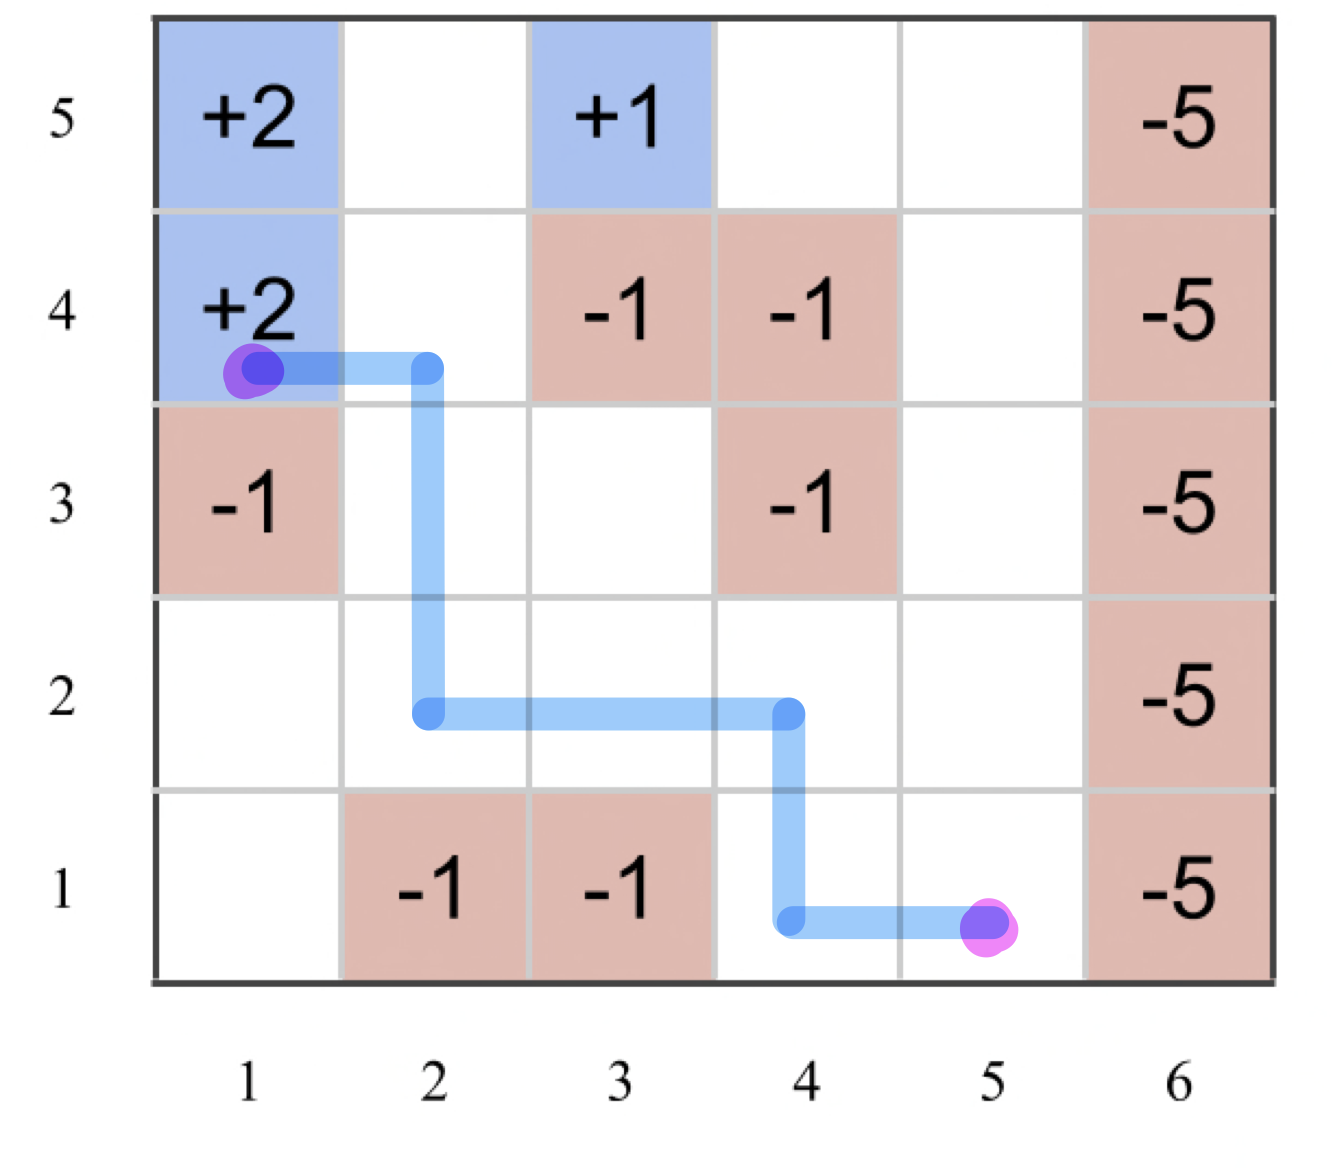

### (1d)

From (3,2) the optimal move is to walk West. If we are trying to go talk to our friends in the Northwest corner, why would we rather do this than walk North first, then West?

You would rather walk west than north at (3, 2) as you would want to avoid the cluster of -1s in the middle of the board.

### (1e)

How painfully awkward do you need to set the default reward for non-terminal states before the optimal move from (5,1) becomes jumping off the balcony immediately and running away?  Round your answer to two decimal places.

In [7]:
x = 0
while True:
    test3 = MDP(nrow = 5, ncol = 6, terminal = {(2,1):-1,
                                             (3,1):-1,
                                             (6,1):-5,
                                             (6,2):-5,
                                             (1,3):-1,
                                             (4,3):-1,
                                             (6,3):-5,
                                             (1,4):2,
                                             (3,4):-1,
                                             (4,4):-1,
                                             (6,4):-5,
                                             (1,5):2,
                                             (3,5):1,
                                             (6,5):-5
                                            }, default_reward = x, discount = .99)
    utility = value_iteration(test3)
    policy = find_policy(test3, utility)
    if policy[(5,1)] == 'E':
        print('Default reward before the optimal path is to jump:', round(x,2))
        break
    x-=.01

Default reward before the optimal path is to jump: -2.01


### (1f)

In **1e** we assumed a certain level of loss (negative reward) just for being present.  But a more realistic approach might be to instead change the reward structure for the terminal states. Consider the terminal states with -1 reward in the default model. Let $R^*$ denote the reward associated with these states. How low does $R^*$ need to be in order for us to immediately jump off the balcony and run away? Use the default non-terminal state reward of -0.01. Write a few sentences interpreting your result.

In [8]:
x = -1
while True:
    test4 = MDP(nrow = 5, ncol = 6, terminal = {(2,1):x,
                                             (3,1):x,
                                             (6,1):-5,
                                             (6,2):-5,
                                             (1,3):x,
                                             (4,3):x,
                                             (6,3):-5,
                                             (1,4):2,
                                             (3,4):x,
                                             (4,4):x,
                                             (6,4):-5,
                                             (1,5):2,
                                             (3,5):1,
                                             (6,5):-5
                                            }, default_reward = -.01, discount = .99)
    utility = value_iteration(test4)
    policy = find_policy(test4, utility)
    if policy[(5,1)] == 'E':
        print('Terminal state reward before the optimal path is to jump:', round(x,2))
        break
    x-=.01

Terminal state reward before the optimal path is to jump: -8.72


### (1g)

Given the problem context, write a few sentences about why this is or is not an appropriate transition model. Include an interpretation of the terminal states.

This is not an appropriate transition model since the the other people at the party are terminal states as well. Wherever there is a -1 on the board is supposed to symbolize a person at the party you don't want to talk to, but ending up at one of those spaces doesn't mean that is where you will be the whole night, and since we have them as terminal states now, if you hit one, you're stuck there. In real life you may take for a bit (which you don't want to do) and then you can move on and continue moving toward your friends.

<br>

---

## Problem 2: HMMs

You are trying to diagnose whether your computer is broken or not. On a given day, your computer's hidden state is either *broken* or *working*. Each day you make one of the following observations: *blue-screen*, *slow*, or *snappy*, depending on the state of your computer. You decide to use the following HMM to model your daily observations. Note, "Emission Distribution" is another way to descibe the "Sensor Distribution".

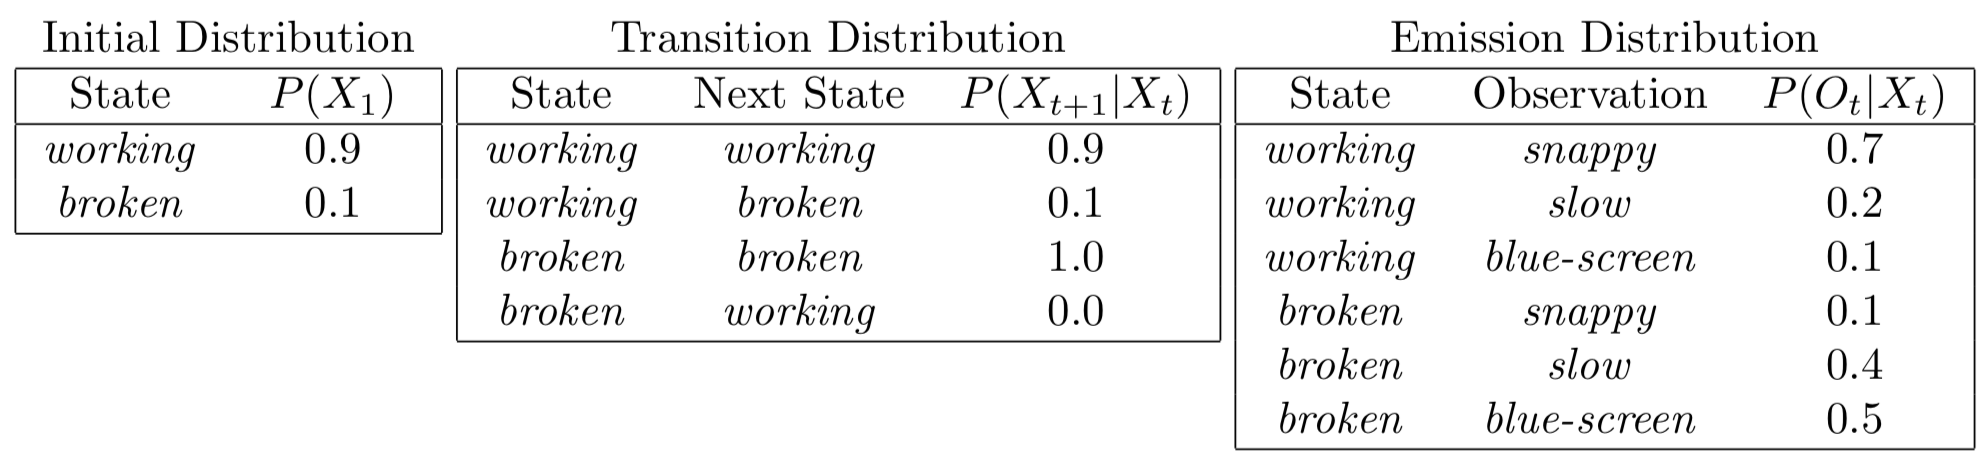


### (2a)
What is the posterior distribution of $X_1$, your computer's state on day one, given the observation (*slow*) on day 1? In other words, find $P(X_1 | E_1 = \textit{slow})$.

$P(X_1=working|O_1=slow) = \alpha \cdot P(O_1=slow|X_1=working) \cdot P(X_1=working) = \alpha \cdot .2 \cdot .9 = .18 \cdot \alpha$\
$P(X_1=broken|O_1=slow) = \alpha \cdot P(O_1=slow|X_1=broken) \cdot P(X_1=broken) = \alpha \cdot .4 \cdot .1 = .04 \cdot \alpha$


$\alpha = \frac{1}{.18+.04} = 4.5454$


$P(X_1=working|O_1=slow) = .18 \cdot \alpha = .8182$\
$P(X_1=broken|O_1=slow) = .04 \cdot \alpha = .1818$


$=\begin{pmatrix} .8182 \\ .1818\end{pmatrix}$

### (2b)
What is the posterior distribution of $X_2$, your computer's state on day two, given the observation sequence (*slow*, *slow*)?

$=\alpha \cdot \begin{pmatrix} .2 & 0 \\ 0 & .4\end{pmatrix}(P(X_2|X_1=broken) \cdot P(X_1=broken|O_1=slow)+P(X_2|X_1=working) \cdot P(X_1=working|O_1=slow))$\
$=\alpha \cdot \begin{pmatrix} .2 & 0 \\ 0 & .4\end{pmatrix}(\begin{pmatrix} 0 \\ .1818 \end{pmatrix} + \begin{pmatrix} .7364 \\ .0818\end{pmatrix})$\
$=\alpha \cdot \begin{pmatrix} .1473 \\ .1054\end{pmatrix} \rightarrow \alpha = \frac{1}{.1473+.1054} = 3.9569$\
$=\begin{pmatrix} .5828 \\ .4172\end{pmatrix}$

<br>

---

## Problem 3: your very own MDP

For this problem, you do not need to write any code, but rather communicate your ideas clearly using complete sentences and descriptions of the concepts the questions ask about. You can, of course, include some pseudocode if it helps, but that is not strictly necessary.

### (3a)

Describe something you think would be interesting to model using a Markov decision process.  Be **creative** - do not use any examples from your homework, class, or the textbook, and if you are working with other students, please **come up with your own example**. There are so, SO many possible answers!

A person at the top of a mountain with many trails going to the bottom, and trying to get to the bottom as fast as possible.

### (3b)

What are the states associated with your MDP?

States could include things such as if the run is groomed, has moguls, or is closed.

### (3c)

What is the reward structure associated with your MDP?  Include a discussion of terminal/non-terminal states.

The reward structure would include a largely positive reward for groomed runs, a slightly positive reward for  trails with moguls, and a negative reward for a run which is closed.

### (3d)

What are the actions and transition model associated with your MDP?

The possible actions would include directions that the person could go at each fork (left, middle, right and so on based on the type of fork)

The transition model would include the probability that a trail is closed while you are getting to it, or that a run gets worse before you get to it.

### (3e)

Interpret what an optimal policy represents in the context of your particular MDP.

An optimal policy in this context would be the path that maximizes groomed runs getting the person to the bottom as fast as possible without hitting closed trails with as few mogul runs as possible.